This notebook gives an overview of how to train a screen recognition model that detects UI elements using Pytorch and Pytorch Lightning using the VINS dataset. 

In [2]:
import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import defaultdict

from PIL import Image, ImageDraw
from screenrecognition.ui_datasets import *
from screenrecognition.ui_models import *
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import *
import torch
import datetime
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
# Where the checkpoints and logs will be stored during training. 
ARTIFACT_DIR = "./checkpoints_screenrecognition_web7k"
CHECK_INTERVAL_STEPS = 100

if not os.path.exists(ARTIFACT_DIR):
    os.makedirs(ARTIFACT_DIR)

## Helper Functions

Here are some helper functions use for getting the class info and to visualize the output of the trained `UIElementDetector`. 

In [4]:
# Loads the map between class indexes and string labels
def loadClassMap(): 
    class_map_file = "metadata/screenrecognition/class_map_vins_manual.json"
    with open(class_map_file, "r") as f:
        class_map = json.load(f)
        
    idx2Label = class_map['idx2Label']
    return idx2Label

In [6]:
# Helper function to draw boxes / predictions on a screenshot
def drawBoxesOnImage(test_image, boxes, labels, idx2Label, scores=[], display_width=400):     
    # Resize the image to be more visible in the cell 
    wpercent = (display_width/float(test_image.size[0]))
    hsize = int((float(test_image.size[1])*float(wpercent)))
    test_image = test_image.resize((display_width, hsize))

    draw = ImageDraw.Draw(test_image)

    conf_thresh = 0.5
    for i in range(len(boxes)):
        conf_score = 100 
        if len(scores) > 0: 
            conf_score = scores[i]
            
        if conf_score > conf_thresh:
            x1, y1, x2, y2 = boxes[i]
            x1 = int(x1) * wpercent
            y1 = int(y1) * wpercent
            x2 = int(x2) * wpercent
            y2 = int(y2) * wpercent
            draw.rectangle([x1, y1, x2, y2], outline='red')
            draw.text((x1, y1), idx2Label[str(int(labels[i]))] + " {:.2f}".format(float(conf_score)), fill="red")
    return test_image

## Download the dataset 
For this exercise, we are going to use the VINS dataset to train our model since it is small. More information about the VINS dataset can be found here https://github.com/sbunian/VINS 

VINS dataset is an annotated dataset containing a representative collection of UI screens across two design stages: abstract wireframes and high-fidelity fully designed interfaces. All of these UIs are annotated with bounding boxes spanning different classes of UI components. The dataset consists of 4,800 images of UI screens of different design stages, collected during different stages of UI design and contains both Android and iPhone screenshots.  

Don't forget to first download the dataset using the script `downloader.py` under downloads. 

After download, the data will be at `downloads/vins/All Dataset`. 

## Intialize Tensorboard logging
We will use Tensorboard to monitor the progress of training and metrics. To initialize it, all you have to do is instantiate the logger given a directory. 

In [7]:
logger = TensorBoardLogger(ARTIFACT_DIR)

To open Tensorboard, run this command in a separate terminal in the root of the materials directory for this notebook. Open the URL given in a browser window. 

`tensorboard --logdir=checkpoints_screenrecognition_web7k/lightning_logs/`

## Initialize the dataset module and inspect the data
For this exercise, we will be using Pytorch and Pytorch lightning which relies on creating a `LightningDataModule` for training tasks to feed the dataset into the model. Below, we initialize the data module for the VINS dataset. The data module has already been created for you and is located in the folder `screenrecognition/ui_datasets.py`

Some parameters you can set are `batch_size` which defines the number of samples passed in a batch for training, and `num_workers` which is the number of subprocesses to use for data loading. You may want to start with a small number of workers and increase as your system allows.  

In [8]:
data = VINSUIDataModule(
    batch_size=8, 
    num_workers=2, 
)

#### Inspect the dataset size
Next, lets take a look around at the dataset. 

In [9]:
print(f"Train: {len(data.train_dataset)}")
print(f"Test: {len(data.test_dataset)}")
print(f"Validation: {len(data.val_dataset)}")

Train: 3364
Test: 722
Validation: 721


#### Get the number of samples in each class, check the distribution
Next, let's look at the contents of the dataset to see how many samples we have for each class and how they are distributed. The class map stores the index of each class to it's string name in the dataset.  

In [10]:
idx2Label = loadClassMap()
idx2Label

{'1': 'OTHER',
 '2': 'Background Image',
 '3': 'Checked View',
 '4': 'Icon',
 '5': 'Input Field',
 '6': 'Image',
 '7': 'Text',
 '8': 'Text Button',
 '9': 'Page Indicator',
 '10': 'Pop-Up Window',
 '11': 'Sliding Menu',
 '12': 'Switch',
 '0': 'BACKGROUND'}

In [11]:
# Counts the number of samples for each class in the dataset. 
def count_samples_per_class(dataset): 
    samples_per_class = defaultdict(int)
    for sample in dataset: 
        labels = sample[1]['labels']
        for label in labels: 
            label_index = str(int(label))
            label_str = idx2Label[label_index]
            samples_per_class[label_str] += 1 
    return samples_per_class

In [12]:
result = count_samples_per_class(data.train_dataset)
result

defaultdict(int,
            {'Text': 21958,
             'Icon': 8563,
             'Text Button': 3494,
             'Input Field': 1756,
             'Image': 6195,
             'Pop-Up Window': 228,
             'OTHER': 3058,
             'Page Indicator': 1024,
             'Sliding Menu': 176,
             'Checked View': 567,
             'Switch': 147,
             'Background Image': 443})

#### Explain the columns
The data consists of a set of `boxes` containing the bounding boxes for each labeled UI element, `labels` which mark their UI element class label, `img` with the original PIL image data, and an `area` tensor (which we will not use in this exercise). 

In [ ]:
data.val_dataset[0][1]

## Train the Model
For this exercise, we will train a UIElementDetector. The model is defined in a LightningModule class under `screenrecognition/ui_models.py`. The `LightningModule` contains the model definitions. 

Look around the `LightningModule` code for `UIElementDetector` to understand how it's set up. 

For this exercise, we will train an object detector on the VINS UI dataset using the `torchvision.models.detection.ssd300_vgg16` base model.  The SSD300 model is based on the SSD: Single Shot MultiBox Detector paper. This article gives a good overview of how it detects objects in a single pass - https://jonathan-hui.medium.com/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06. 

However, you may try out using other base models, such as Faster-RCNN model, here. https://pytorch.org/vision/main/models.html#object-detection

In [14]:
FINETUNE_CLASSES = 13 # There are 13 possible UI element classes, 
                        # but we do not have any samples of the `BACKGROUND` class in the training dataset. 

#### Initialize the UIElementDetector 
Instantiate the UIElementDetector, and set the learning rate parameter. The arch should be `ssd` to start to use the single-shot multi box detector. 

(Look around the code for the UIElementDetector LightningModule)

In [21]:
model = UIElementDetector(num_classes=FINETUNE_CLASSES, lr=0.01, arch="ssd")

#### Define checkpoint callbacks. 

Define the checkpoint callback functions. Each `ModelCheckpoint` tells pytorch to save a checkpoint based on certain paramters, such as `every_n_train_steps`, etc. The second `checkpoint_callback2` monitors the mAP and saves the checkpoints that have the highest `mAP` score. 

In [17]:
checkpoint_callback = ModelCheckpoint(dirpath=ARTIFACT_DIR, every_n_train_steps=10, save_last=True)
checkpoint_callback2 = ModelCheckpoint(dirpath=ARTIFACT_DIR, filename= "screenrecognition", monitor='mAP', mode="max", save_top_k=1)
earlystopping_callback = EarlyStopping(monitor="mAP", mode="max", patience=10)

#### Setup the Trainer 

The `Trainer` setup is where you define the `accelerator` which can be 'cpu', 'gpu', 'mps' for the device. Feel free to set this to whatever you have available on your machine. You can define other parameters here, such as the min and `max_epochs`, gradient clipping, etc. 

Read more on gradient clipping here if you want to learn more: https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem#:~:text=Gradient%20Clipping%20is%20a%20method,gradients%20to%20update%20the%20weights

Detailed docs for the `Trainer` class and options: https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html

In [18]:
trainer = Trainer(
    accelerator='cpu', 
    precision=32, # Floating point precion 
    gradient_clip_val=1.0, # Gradient clipping values. 
    accumulate_grad_batches=2,
    callbacks=[checkpoint_callback, checkpoint_callback2, earlystopping_callback],
    val_check_interval=
    10,
    min_epochs=10,
    max_epochs=100,
    logger=logger, 
    log_every_n_steps=10
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aswearngin/miniforge3/envs/cix-new/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Finally, start training by calling `fit` on the model and the data module. For this exercise, try training the model until you see some checkpoints stored in CHECKPOINTS_DIR and adjust hyperparameters as needed. However, you may not see results on training this model locally within the class session, so we have trained model checkpoints you can evaluate for the following notebooks. 

In [22]:
trainer.fit(model, data)


  | Name  | Type | Params
-------------------------------
0 | model | SSD  | 25.2 M
-------------------------------
25.2 M    Trainable params
0         Non-trainable params
25.2 M    Total params
100.865   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

mAP: 0.0019625856075435877


Training: 20it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

mAP: 2.7196363134862622e-06


Validation: 0it [00:00, ?it/s]

mAP: 2.1853479665878695e-06


Validation: 0it [00:00, ?it/s]

## Evaluate the trained model 
After getting a model checkpoint, you can try calling the trained model on an example screenshot to visualize the output. 

In [23]:
test_image = Image.open("example.jpg")

In [24]:
model_path = os.path.join(ARTIFACT_DIR, 'screenrecognition.ckpt') # Define the checkpoint path. 
model = UIElementDetector.load_from_checkpoint(model_path).eval() 

Use `transforms` to convert the PIL image to a tensor for passing the model. Then get the predicted output from the screenshot. 

In [25]:
img_transforms = transforms.ToTensor()
img_input = img_transforms(test_image)

# Pass in the input tensor to the model to get the predictions
pred = model.model([img_input])

Finally, use the helper function `drawBoxesOnImage` to view the output of the  model on a screenshot. 

In [26]:
boxes = pred[0]["boxes"]
labels = pred[0]["labels"]
scores = pred[0]["scores"]
idx2Label = loadClassMap()

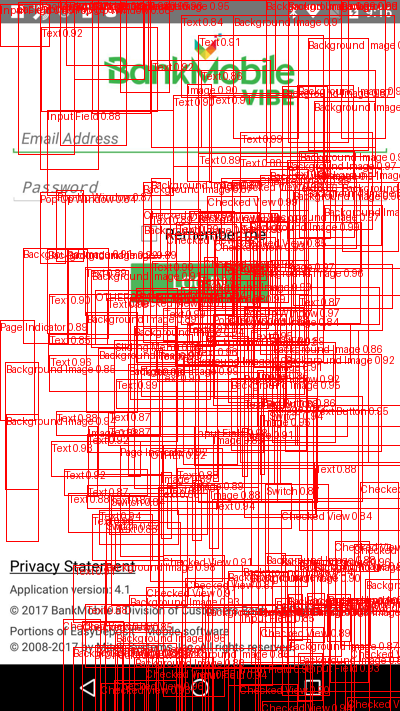

In [27]:
drawBoxesOnImage(test_image, boxes, labels, idx2Label, scores=scores, display_width=400)

This object detection model may take hours to train effectively, so you may just see a bunch of crazy boxes above if you have only trained for a few minutes. That's expected. 

## Fine tune on top of WebUI checkpoint instead

You may notice that when training the model above, the `mAP` starts off very low with a very high loss. The WebUI dataset and checkpoints let us use a base model checkpoint trained on WebUI data to boostrap the model and fine tune it on the VINS dataset. Here is how to give that a try below. 

In [28]:
FINETUNE_CLASSES = 13
model = UIElementDetector.load_from_checkpoint('downloads/checkpoints/screenrecognition-web350k-vins.ckpt', val_weights=None, lr=0.0001) # use best checkpoint
model.hparams.num_classes = FINETUNE_CLASSES

Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file downloads/checkpoints/screenrecognition-web350k-vins.ckpt`


In [29]:
mod = model.model.head.classification_head
model.model.head.classification_head.cls_logits = torch.nn.Conv2d(mod.cls_logits.in_channels, mod.num_anchors * FINETUNE_CLASSES, kernel_size=3, stride=1, padding=1)
model.model.head.classification_head.num_classes = FINETUNE_CLASSES
model.hparams.num_classes = FINETUNE_CLASSES

In [30]:
checkpoint_callback = ModelCheckpoint(dirpath=ARTIFACT_DIR, every_n_train_steps=CHECK_INTERVAL_STEPS, save_last=True)
checkpoint_callback2 = ModelCheckpoint(dirpath=ARTIFACT_DIR, filename= "screenrecognition",monitor='mAP', mode="max", save_top_k=1)

earlystopping_callback = EarlyStopping(monitor="mAP", mode="max", patience=10)

In [31]:
trainer = Trainer(
    accelerator='cpu',
    gradient_clip_val=1.0,
    accumulate_grad_batches=2,
    callbacks=[checkpoint_callback, checkpoint_callback2, earlystopping_callback],
    val_check_interval=
    10,
    min_epochs=10,
    max_epochs=100,
    logger=logger, 
    log_every_n_steps=10
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(model, data)


  | Name  | Type | Params
-------------------------------
0 | model | FCOS | 32.1 M
-------------------------------
32.1 M    Trainable params
0         Non-trainable params
32.1 M    Total params
128.359   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

mAP: 0.06479126960039139


Training: 0it [00:00, ?it/s]

GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])


Validation: 0it [00:00, ?it/s]

mAP: 0.03554687649011612
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])


Validation: 0it [00:00, ?it/s]

mAP: 0.0355243943631649
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 3840, 13])
All GT: torch.Size([8, 3840])
FG mask: torch.Size([8, 3840])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])
GT: torch.Size([8, 4265, 13])
All GT: torch.Size([8, 4265])
FG mask: torch.Size([8, 4265])


Process Process-17:
Process Process-27:
Process Process-18:
Process Process-28:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aswearngin/miniforge3/envs/cix-new/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/Users/aswearngin/miniforge3/envs/cix-new/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/Users/aswearngin/miniforge3/envs/cix-new/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/Users/aswearngin/miniforge3/envs/cix-new/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/Users/aswearngin/miniforge3/envs/cix-new/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/Users/aswearngin/miniforge3/envs/cix-new/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstat

RuntimeError: DataLoader worker (pid 17574) is killed by signal: Interrupt: 2. 

How does the behavior of this model compare to the prior model? Do you see any difference in the initial checkpoints or in the tensorboard graphs for loss or mAP? Use the methods above for evaluating the trained model output on this the version fine tuned on top of WebUI. 